##  Journey to BERT fine tunning

Мы будем использовать нашумевшую архитектуру BERT из `transformers` библиотеки для решения задачи классификации русских твитов.

Данные хранятся тут: https://study.mokoron.com/
это важный датасет для русского комьюнити, содержащие позитивные и негативные твиты на русском языке.

In [1]:
! pip install transformers

     |████████████████████████████████| 675kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 17.2MB/s 
     |████████████████████████████████| 890kB 24.9MB/s 
     |████████████████████████████████| 3.8MB 30.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7f6860be26c2ea08c7efa1aa4ef18dcd307e4acf4f69b1422d3c8639b6e5b271
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import matplotlib.pyplot as plt

Using TensorFlow backend.


Этот ноутбук можно выполнить даже с помощью только CPU. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


## Загрузка данных


Мы выбрали не очень известный, необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
pos_texts = pd.read_csv('/content/gdrive/My Drive/RuTweetCorp/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('/content/gdrive/My Drive/RuTweetCorp/negative.csv', encoding='utf8', sep=';', header=None)

In [ ]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
75323,410645620597063680,1386740520,LinaAverinaa,RT @twiterskayabelk: @LinaAverinaa атлична а у...,1,0,1,0,9849,1063,967,2
19901,409409029161902081,1386445693,Luguitep,RT @Creative_Link: Иван Царевич и Серый Волк -...,1,0,944,0,51,0,195,0
10611,409289518509199360,1386417200,katy_velikanova,"К мужчинам, у которых партнерша аппетитных фор...",1,0,0,0,15318,109,24,3
11971,409306865173274624,1386421335,mlerman23,@Aleksandrovna29 я люблю тебя мои новогодние ш...,1,0,0,0,2861,56,52,0
33676,409759927993769984,1386529354,unicorn_in_hell,@durashka_69 сладких снов ^_^ \nдай обниму пер...,1,0,1,0,3353,563,947,0


In [ ]:
neg_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
111446,425007010665345024,1390164542,Mr_Sanzharov,RT @Heilig_99: В вк нет этих фоооточек(((((,-1,0,1,0,38312,270,123,13
24130,411986287844159490,1387060160,ovygisysea,"RT @upedodag: Блин, я неудачник. Подорвал попк...",-1,0,3,0,404,202,174,0
110469,424844481763241985,1390125792,James_Bond__47,"как же хорошо дома, выходные прошли мимо меня,...",-1,0,0,0,2893,37,91,0
54203,415687348941496320,1387942561,KatYasnickaya,"Срезовая по химии, контрольная по геометрии, т...",-1,0,0,0,957,33,18,0
86589,421147223812878336,1389244297,freedom1420,@madman19_89 вот это правильно\nИ какую захоте...,-1,0,0,0,5943,198,101,0


Разметка предложений для BERT: добавляем в начало и конец предложения токены [CLS] и [SEP]

In [6]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ['[CLS] ' + sent + ' [SEP]' for sent in sentences]

# correct labels
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [ ]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [ ]:
print(sentences[100], labels[100])
print(sentences[-100], labels[-100])

[CLS] @jolechka3 получается,осторожно котлетку перекладываю в др.посуду) [SEP] [1]
[CLS] @LizHorbenko я по-тихоньку, у меня сессия в самом разгаре, ненавижу экономику, мат.анализ и естествознание ;( [SEP] [0]


In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [ ]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
%%time
from transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences] #sentences
print(tokenized_texts[0])


['[CLS]', '@', 'ali', '##nam', '##ary', '##sia', '##a', '##9', '##6', 'э', '##э', '##э', '##и', '!', '!', '!', '!', 'а', 'к', '##а', '##к', 'ж', '##е', 'я', '?', '?', 'з', '##а', '##б', '##ы', '##л', '##а', 'у', '##ж', '##е', 'п', '##р', '##о', 'л', '##у', '##ч', '##ш', '##у', '##ю', 'п', '##о', '##д', '##р', '##у', '##г', '##у', '(', '(', '(', '(', '(', '(', '(', '(', '(', '[SEP]']
CPU times: user 1min 19s, sys: 635 ms, total: 1min 20s
Wall time: 1min 21s


In [ ]:
train_sentences[0]

'[CLS] Как доказать девушке,что я ее люблю? — Не знааю, все девушки разные:) кто-то и так верит:3 http://t.co/dGyMSvOArj [SEP]'

BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 100). 

Теперь более длинные предложения будем обрезать до 100 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию `pad_sequences` из библиотеки `keras`.



In [ ]:
%%time
input_ids = [ tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# padding
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

CPU times: user 20.5 s, sys: 366 ms, total: 20.9 s
Wall time: 20.9 s


Делим данные на `train` и `val`:

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразуем данные в `pytorch` тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

Воспользуемся классом `DataLoader`. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет `Memory Error`, размер батча необходимо уменьшить.

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from transformers import AdamW, BertForSequenceClassification

Загружаем BERT. `bert-base-uncased` - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [ ]:
%%time
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)
print(1)


1
CPU times: user 12.6 s, sys: 2.71 s, total: 15.3 s
Wall time: 27 s


### Обучение
Теперь обсудим гиперпараметры для обучения нашей модели. Авторы статьи советуют выбирать `learning rate` `5e-5`, `3e-5`, `2e-5`, а количество эпох не делать слишком большим, 2-4 вполне достаточно. Мы пойдем еще дальше и попробуем дообучить нашу модель всего за одну эпоху.

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=1024 )

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=1024 )

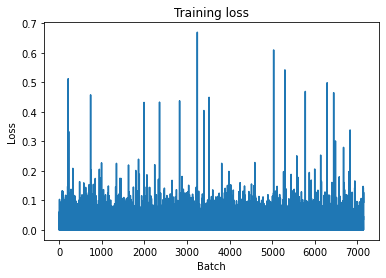

Loss на обучающей выборке: 0.03152


AttributeError: ignored

In [ ]:
#%%time
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    train_inputs, train_mask, train_labels = batch
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    # Forward pass
    loss = model(train_inputs, attention_mask=train_mask, token_type_ids=None, labels=train_labels)[0]
    print (loss)
    train_loss_set.append(loss)
    # Backward pass
    loss.backward()
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()
    # Обновляем loss
    train_loss += loss
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    val_inputs, val_mask, val_labels = batch
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(val_inputs, token_type_ids=None, attention_mask=val_mask) 
    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits.detach().cpu().numpy()
    label_ids = val_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

    print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
        accuracy_score(valid_labels, valid_preds) * 100
    ))

In [ ]:
%%time
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    val_inputs, val_mask, val_labels = batch
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(val_inputs, token_type_ids=None, attention_mask=val_mask)[0]
    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits.detach().cpu().numpy()
    label_ids = val_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
        accuracy_score(valid_labels, valid_preds) * 100
    ))

Процент правильных предсказаний на валидационной выборке: 98.14%
CPU times: user 33.7 s, sys: 13.9 s, total: 47.6 s
Wall time: 47.6 s


In [ ]:
print("Результат: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [ ]:
model_save_name = 'BERT-twitter-1epoch.net'
path = f"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Оценка качества на отложенной выборке

Качество на валидационной выборке оказалось очень хорошим. Не переобучилась ли наша модель?

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [ tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
tokenized_texts[0]

Создаем attention маски и приводим данные в необходимый формат:

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=1024
)

In [ ]:
%%time
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    batch_inputs, batch_mask, batch_labels = batch
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(batch_inputs, token_type_ids=None, attention_mask=batch_mask)[0]

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    
    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

CPU times: user 6min 58s, sys: 4min 41s, total: 11min 40s
Wall time: 11min 40s


In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 98.11%


In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    len([i for i, j in zip(test_labels, test_preds) if i != j]),
    len(test_labels)
))
print ('{0:.2f}%'.format(len([i for i, j in zip(test_labels, test_preds) if i != j])/len(test_labels) * 100))

Неправильных предсказаний: 1287/68051
1.89%


### Оценка качества работы без fine-tuning

In [ ]:
model_wo_finetuning = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_wo_finetuning.cuda()

In [ ]:
%%time
model_wo_finetuning.eval()
preds_wo_finetuning, labels_wo_finetuning = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model_wo_finetuning(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    preds_wo_finetuning.extend(batch_preds)
    labels_wo_finetuning.extend(batch_labels)

In [ ]:
acc_score_wo_finetuning = accuracy_score(labels_wo_finetuning, preds_wo_finetuning)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score_wo_finetuning*100
))

Процент правильных предсказаний на отложенной выборке составил: 49.63%


Сравним точность и полноту предсказаний:

In [ ]:
from sklearn.metrics import recall_score, precision_score

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))
 
print('Без дообучения: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
    recall_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
))

1 эпоха: точность (precision) 99.95%, полнота (recall) 96.30%
Без дообучения: точность (precision) 61.90%, полнота (recall) 0.79%


### Другие модели

В данный момент улучшениями над бертом являются следующие модели: XL-net and RoBERTA, причем вторая это просто качественнее тренированная модель.

А давайте проверим, как они работают в нашем случае при finetunnig. 

In [7]:
def prepare_data(pos_texts, neg_texts, batch_size):
  sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])
  sentences = ['[CLS] ' + sent + ' [SEP]' for sent in sentences]
  labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]
  train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  ### TRAIN: ###
  tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
  input_ids = [ tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  # padding
  input_ids = pad_sequences(
      input_ids,
      maxlen=100,
      dtype="long",
      truncating="post",
      padding="post"
  )

  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

  train_masks, validation_masks, _, _ = train_test_split(
      attention_masks,
      input_ids,
      random_state=42,
      test_size=0.1
  )

  train_inputs = torch.tensor(train_inputs)
  train_labels = torch.tensor(train_labels)
  train_masks = torch.tensor(train_masks)

  validation_inputs = torch.tensor(validation_inputs)
  validation_labels = torch.tensor(validation_labels)
  validation_masks = torch.tensor(validation_masks)

  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size )
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=batch_size )
  print('data for train ready')

  ### TEST: ###
  tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
  input_ids = [ tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  input_ids = pad_sequences(
      input_ids,
      maxlen=100,
      dtype="long",
      truncating="post",
      padding="post"
  )

  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
  prediction_labels = torch.tensor(test_gt)

  prediction_data = TensorDataset(
      prediction_inputs,
      prediction_masks,
      prediction_labels
  )

  prediction_dataloader = DataLoader(
      prediction_data, 
      sampler=SequentialSampler(prediction_data),
      batch_size=batch_size
  )
  print('data for test ready')
  return train_dataloader, validation_dataloader, prediction_dataloader

In [8]:
def train_model(model, train_dataloader):

  #define optimizer:
  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

  # Будем сохранять loss во время обучения
  # и рисовать график в режиме реального времени
  train_loss_set = []
  train_loss = 0

  # Обучение
  # Переводим модель в training mode
  model.train()

  for step, batch in enumerate(train_dataloader):
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      # Распаковываем данные из dataloader
      train_inputs, train_mask, train_labels = batch
      # если не сделать .zero_grad(), градиенты будут накапливаться
      optimizer.zero_grad()
      # Forward pass
      loss = model(train_inputs, attention_mask=train_mask, token_type_ids=None, labels=train_labels)[0]
      print (loss)
      train_loss_set.append(loss)
      # Backward pass
      loss.backward()
      # Обновляем параметры и делаем шаг используя посчитанные градиенты
      optimizer.step()
      # Обновляем loss
      train_loss += loss
      # Рисуем график
      clear_output(True)
      plt.plot(train_loss_set)
      plt.title("Training loss")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
      
  print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

  return train_loss_set

In [9]:
def val_model(model, validation_dataloader):
  # Валидация
  # Переводим модель в evaluation mode
  model.eval()

  valid_preds, valid_labels = [], []

  for batch in validation_dataloader:   
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      # Распаковываем данные из dataloader
      val_inputs, val_mask, val_labels = batch
      # При использовании .no_grad() модель не будет считать и хранить градиенты.
      # Это ускорит процесс предсказания меток для валидационных данных.
      with torch.no_grad():
          logits = model(val_inputs, token_type_ids=None, attention_mask=val_mask)[0]
      # Перемещаем logits и метки классов на CPU для дальнейшей работы
      logits = logits.detach().cpu().numpy()
      label_ids = val_labels.to('cpu').numpy()
      
      batch_preds = np.argmax(logits, axis=1)
      batch_labels = np.concatenate(label_ids)     
      valid_preds.extend(batch_preds)
      valid_labels.extend(batch_labels)

      acc_score = accuracy_score(valid_labels, valid_preds)
  print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
          acc_score * 100
      ))
  return acc_score

In [ ]:
from sklearn.metrics import recall_score, precision_score
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))

In [26]:
def test_model(model, prediction_dataloader):
  model.eval()
  test_preds, test_labels = [], []

  for batch in prediction_dataloader:
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      # Распаковываем данные из dataloader
      batch_inputs, batch_mask, batch_labels = batch
      # При использовании .no_grad() модель не будет считать и хранить градиенты.
      # Это ускорит процесс предсказания меток для тестовых данных.
      with torch.no_grad():
          logits = model(batch_inputs, token_type_ids=None, attention_mask=batch_mask)[0]

      # Перемещаем logits и метки классов на CPU для дальнейшей работы
      logits = logits.detach().cpu().numpy()
      label_ids = batch_labels.to('cpu').numpy()
      
      # Сохраняем предсказанные классы и ground truth
      batch_preds = np.argmax(logits, axis=1)
      batch_labels = np.concatenate(label_ids)  
      test_preds.extend(batch_preds)
      test_labels.extend(batch_labels)

  acc_score = accuracy_score(test_labels, test_preds)
  print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
  acc_score*100
  ))

  print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
  ))
  return test_preds, test_labels

In [10]:
%%time
train_dataloader, val_dataloader, pred_dataloader = prepare_data(pos_texts, neg_texts, batch_size=16)


data for train ready
data for test ready
CPU times: user 2min 29s, sys: 1.73 s, total: 2min 30s
Wall time: 2min 31s


In [11]:
from transformers import XLNetForSequenceClassification, RobertaForSequenceClassification

In [19]:
%%time
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
roberta_model.to(device)


CPU times: user 14.2 s, sys: 2.01 s, total: 16.2 s
Wall time: 34.9 s


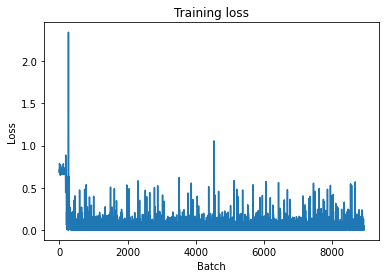

Loss на обучающей выборке: 0.05747


AttributeError: ignored

In [ ]:
%%time
loss_roberta = train_model(roberta_model, train_dataloader, val_dataloader)

In [ ]:
%%time
val_roberta = val_model(roberta_model, val_dataloader)

Процент правильных предсказаний на валидационной выборке: 95.89%
CPU times: user 1min 57s, sys: 1min 4s, total: 3min 2s
Wall time: 3min 2s


In [ ]:
model_save_name = 'RoBERTa-twitter-1epoch.net'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(roberta_model.state_dict(), path)

In [20]:
model_save_name = 'RoBERTa-twitter-1epoch.net'
path = f"/content/gdrive/My Drive/{model_save_name}"
roberta_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
xlnet_model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
xlnet_model.to(device)

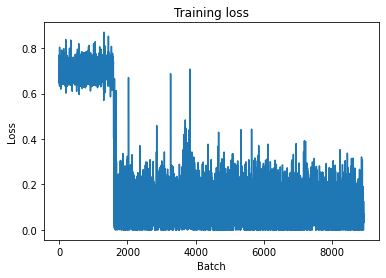

Loss на обучающей выборке: 0.20537
CPU times: user 1h 42min 12s, sys: 37min 50s, total: 2h 20min 3s
Wall time: 2h 18min 56s


In [ ]:
%%time
loss_xlnet = train_model(xlnet_model, train_dataloader)

In [ ]:
model_save_name = 'XLNet-twitter-1epoch.net'
path = f"/content/gdrive/My Drive/{model_save_name}"
torch.save(xlnet_model.state_dict(), path)

In [14]:
model_save_name = 'XLNet-twitter-1epoch.net'
path = f"/content/gdrive/My Drive/{model_save_name}"
xlnet_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [15]:
%%time
val_xlnet = val_model(xlnet_model, val_dataloader)

Процент правильных предсказаний на валидационной выборке: 95.14%
CPU times: user 59.6 s, sys: 18 s, total: 1min 17s
Wall time: 1min 15s


In [22]:
from sklearn.metrics import recall_score, precision_score

In [27]:
%%time
#качество на тесте
print('XLNet')
test_model(xlnet_model, pred_dataloader)

XLNet
Процент правильных предсказаний на отложенной выборке составил: 95.28%
1 эпоха: точность (precision) 91.45%, полнота (recall) 100.00%
CPU times: user 3min 57s, sys: 1min 16s, total: 5min 14s
Wall time: 5min 1s


In [28]:
%%time
#качество на тесте
print('RoBERTa')
test_model(roberta_model, pred_dataloader)

RoBERTa
Процент правильных предсказаний на отложенной выборке составил: 95.99%
1 эпоха: точность (precision) 92.65%, полнота (recall) 99.98%
CPU times: user 2min 35s, sys: 55.2 s, total: 3min 30s
Wall time: 3min 30s


## Итог 

Здесь мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Обратите внимание, что мы не тюнили параметры и использовали сравнительно небольшой размеченный корпус, чтобы получить accuracy больше 98\%. Тем не менее, если не делать дообучения под конкретную задачу вовсе, получить хорошее качество не удается.

Кроме того, мы познакомились с библиотекой `transformers`, которая позволяет использовать готовые обертки над моделями, специально созданными для решения той или иной задачи. Использовать BERT при решении повседневных NLP задач совсем нетрудно: не нужно даже вручную скачивать веса модели, библиотека все сделает за вас. Отбросив необходимость чуть-чуть предобработать тексты, сложность применения предобученного BERT'а оказывается не сильно больше, чем импортировать и применить лог.регрессию из `sklearn`.